In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.models import resnet18
from torchvision.datasets import ImageFolder
from torch import nn, optim
from torch.utils.data import DataLoader
from tqdm import tqdm
import copy

In [2]:
print(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

cuda


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

IMG_SIZE = 224
BATCH_SIZE = 32
NUM_CLASSES = 3
EPOCHS = 5
PATIENCE = 3
LEARNING_RATE = 1e-4

In [5]:
train_path = r'C:\Users\Admin\Desktop\Video Classification\dataset\train'
val_path = r'C:\Users\Admin\Desktop\Video Classification\dataset\val'
checkpoint_path = 'best_resnet_model.pt'

In [6]:
# Transforms
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])


In [7]:
train_dataset = ImageFolder(train_path, transform=transform)
val_dataset = ImageFolder(val_path, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, num_workers=2, pin_memory=True)

In [8]:
model = resnet18(weights='IMAGENET1K_V1')
model.fc = nn.Linear(model.fc.in_features, NUM_CLASSES)
model = model.to(device)

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
best_loss = float('inf')
patience_counter = 0

In [10]:
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(EPOCHS):
    model.train()
    train_loss, correct = 0.0, 0

    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} - Training"):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)
        correct += (outputs.argmax(1) == labels).sum().item()

    avg_train_loss = train_loss / len(train_loader.dataset)
    train_acc = correct / len(train_loader.dataset)

    # Validation
    model.eval()
    val_loss, val_correct = 0.0, 0

    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc="Validation"):
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * images.size(0)
            val_correct += (outputs.argmax(1) == labels).sum().item()

    avg_val_loss = val_loss / len(val_loader.dataset)
    val_acc = val_correct / len(val_loader.dataset)

    print(f"Epoch {epoch+1}: "
          f"Train Loss={avg_train_loss:.4f}, Acc={train_acc:.4f} | "
          f"Val Loss={avg_val_loss:.4f}, Acc={val_acc:.4f}")
    
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_acc)
    
    # Early stopping
    if avg_val_loss < best_loss:
        best_loss = avg_val_loss
        best_model = copy.deepcopy(model.state_dict())
        patience_counter = 0
        torch.save(best_model, checkpoint_path)
        print("Saved new best model")
    else:
        patience_counter += 1
        print(f"Patience count: {patience_counter}")
        if patience_counter >= PATIENCE:
            print("Early stopping triggered")
            break

Validation: 100%|██████████| 79/79 [00:15<00:00,  4.95it/s]


Epoch 1: Train Loss=0.1243, Acc=0.9512 | Val Loss=0.0713, Acc=0.9736
Saved new best model


Validation: 100%|██████████| 79/79 [00:14<00:00,  5.51it/s]


Epoch 2: Train Loss=0.0275, Acc=0.9913 | Val Loss=0.0460, Acc=0.9820
Saved new best model


Validation: 100%|██████████| 79/79 [00:14<00:00,  5.64it/s]


Epoch 3: Train Loss=0.0211, Acc=0.9937 | Val Loss=0.0478, Acc=0.9836
Patience count: 1


Validation: 100%|██████████| 79/79 [00:12<00:00,  6.09it/s]


Epoch 4: Train Loss=0.0176, Acc=0.9943 | Val Loss=0.0628, Acc=0.9800
Patience count: 2


Validation: 100%|██████████| 79/79 [00:12<00:00,  6.21it/s]

Epoch 5: Train Loss=0.0145, Acc=0.9955 | Val Loss=0.0380, Acc=0.9856
Saved new best model


In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

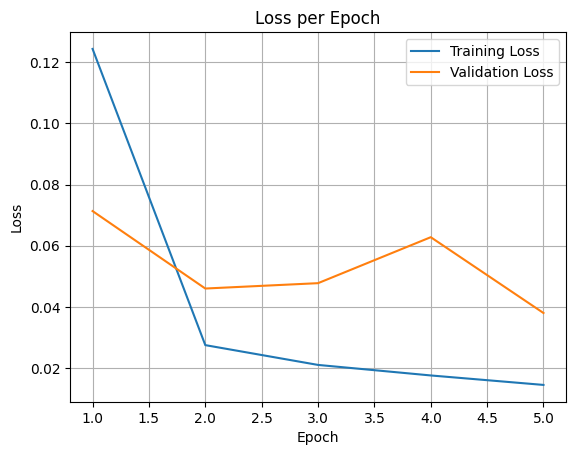

In [13]:
epoch_list = list(range(1, len(train_losses) + 1))
# Plot Loss
plt.figure()
plt.plot(epoch_list, train_losses, label='Training Loss')
plt.plot(epoch_list, val_losses, label='Validation Loss')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

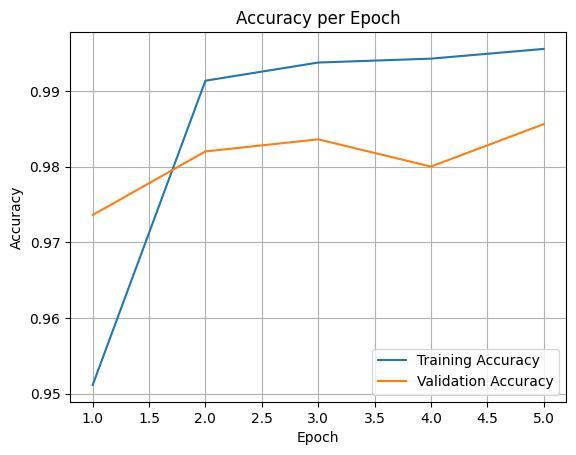

In [14]:
# Plot Accuracy
plt.figure()
plt.plot(epoch_list, train_accuracies, label='Training Accuracy')
plt.plot(epoch_list, val_accuracies, label='Validation Accuracy')
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [10]:
# Load best model
model.load_state_dict(torch.load(checkpoint_path))
model.to(device)

C:\Users\Admin\AppData\Local\Temp\ipykernel_24764\2291665895.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint_path))


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [10]:
test_path = r'C:\Users\Admin\Desktop\Video Classification\dataset\test'
# Test dataset and loader
test_dataset = ImageFolder(test_path, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, num_workers=2, pin_memory=True)


C:\Users\Admin\AppData\Local\Temp\ipykernel_24188\420592832.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_resnet_model.pt', map_


Test Accuracy: 98.72%


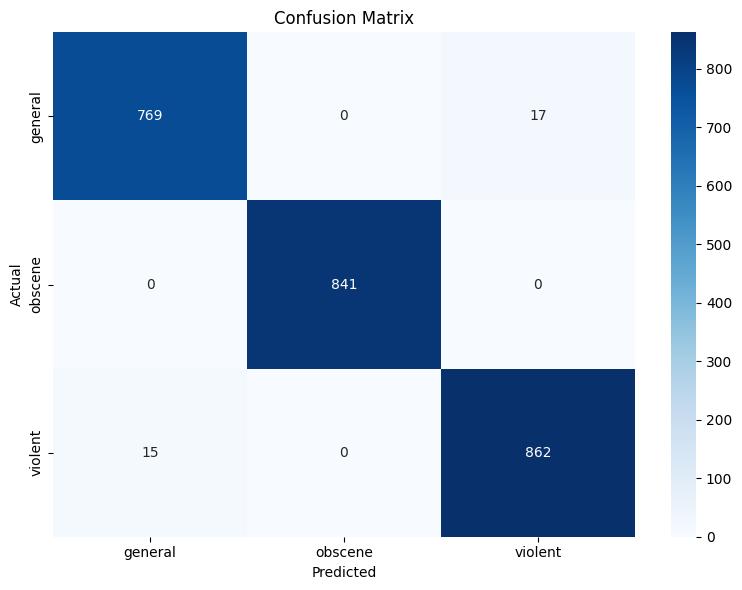


Classification Report:
              precision    recall  f1-score   support

     general       0.98      0.98      0.98       786
     obscene       1.00      1.00      1.00       841
     violent       0.98      0.98      0.98       877

    accuracy                           0.99      2504
   macro avg       0.99      0.99      0.99      2504
weighted avg       0.99      0.99      0.99      2504



In [15]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

class_names = ['general', 'obscene', 'violent']

# Load model
model.load_state_dict(torch.load('best_resnet_model.pt', map_location=device))
model = model.to(device)
model.eval()

correct = 0
total = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)

        correct += (preds == labels).sum().item()
        total += labels.size(0)

        all_preds.extend(preds.cpu().tolist())
        all_labels.extend(labels.cpu().tolist())

# Accuracy
accuracy = correct / total * 100
print(f"\nTest Accuracy: {accuracy:.2f}%")

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# Classification Report
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))